# sep 1.4.1 Tutorial 

### These are the basic steps of using SEP to detect objects in an image and perform basic aperture photometry. 

###### Based on the tutorial provided. 

#### In this case, we will use astropy.io.fits to read the rest image. 

In [2]:
import numpy as np 
import sep 

In [3]:
#more set up steps 
from astropy.io import fits
import matplotlib.pyplot as plt 
from matplotlib import rcParams 

%matplotlib inline 

rcParams['figure.figsize'] = [10.,8.]

##### First, we'll read an example image from an astropy file and display it. 

In [4]:
#open astropy fits 
from astropy.utils.data import download_file

image_file = download_file(
    "http://data.astropy.org/tutorials/FITS-images/HorseHead.fits", cache=True
)

### Open FITS files and loading the image data 

In [5]:
hdu_list = fits.open(image_file) 
hdu_list.info()

Filename: /Users/lorenalzona/.astropy/cache/download/url/ff6e0b93871033c68022ca026a956d87/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


#### The image info is located in the PRIMARY block. The blocks are numbered and can be accessed by indexing hdu_list. 

In [6]:
image_data = hdu_list[0].data 

print(type(image_data)) 
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


In [7]:
image_data = hdu_list[0].data 

##### We can close the FITS file because we have stored everything we needed to a variable. Closing the file will ensure that it can't continue using excess memory or file handes on the computer.

In [8]:
hdu_list.close()

### Now we can show the image. 

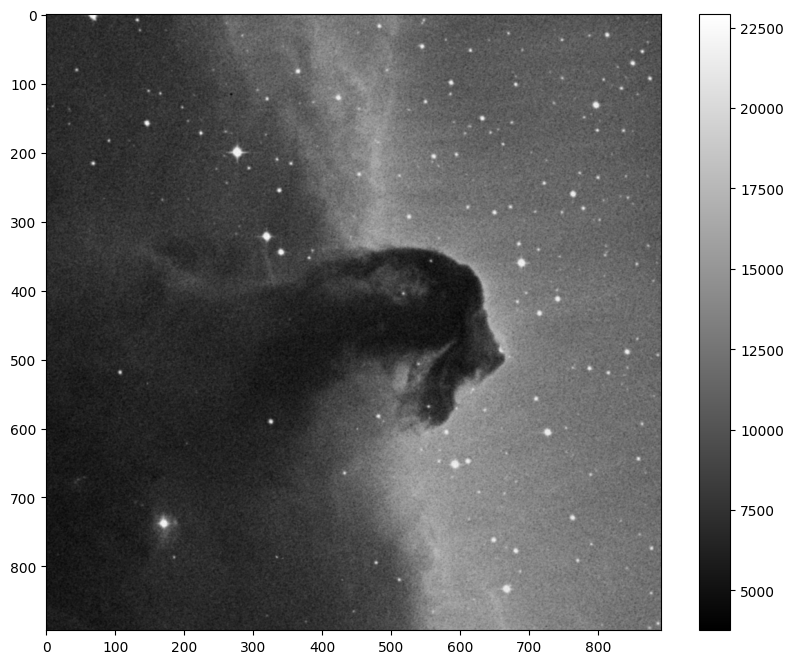

In [40]:
plt.imshow(image_data, cmap="gray") 
plt.colorbar()

plt.savefig("image-data.png",bbox_inches='tight',facecolor='white')

### Now we'll subtract the background. But first, we need to prepare the image for SEP. It needs float32 or float64.

In [11]:
data = np.asarray(image_data,dtype=np.float64)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [13]:
#measure a spatially varying background on the image 
image_data = image_data.astype(image_data.dtype.newbyteorder('='))
bkg = sep.Background(data) 

#### Now we want to get a global mean and noise of the image background.

In [37]:
print(bkg.globalback)
print(bkg.globalrms) 

9154.8564453125
583.5933837890625


In [38]:
#evaluate background as a 2d array 
bkg_image = bkg.back()

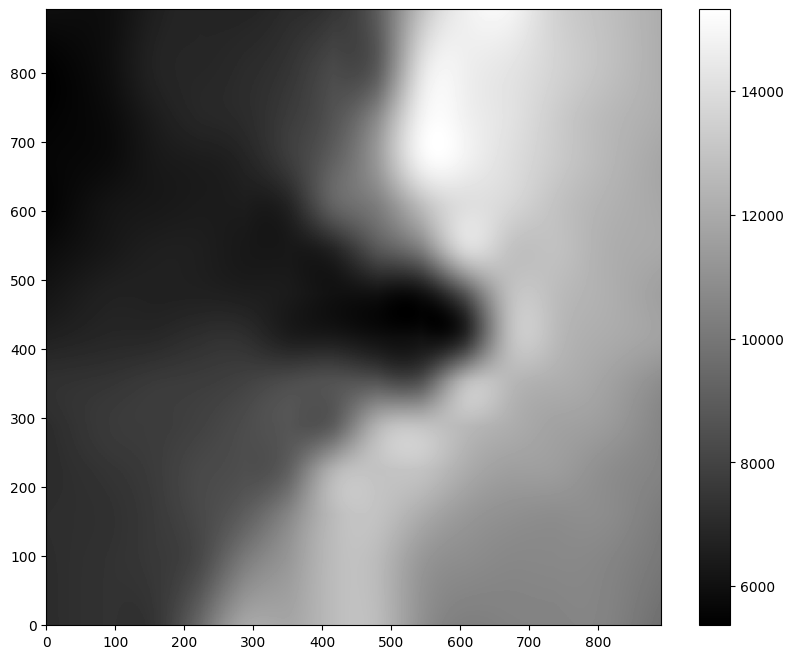

In [41]:
plt.imshow(bkg_image, interpolation='nearest',cmap='gray', origin='lower')
plt.colorbar();

plt.savefig("background-image.png",bbox_inches='tight',facecolor='white') 

In [42]:
#eval background noise as a 2d array
bkg_rms = bkg.rms()

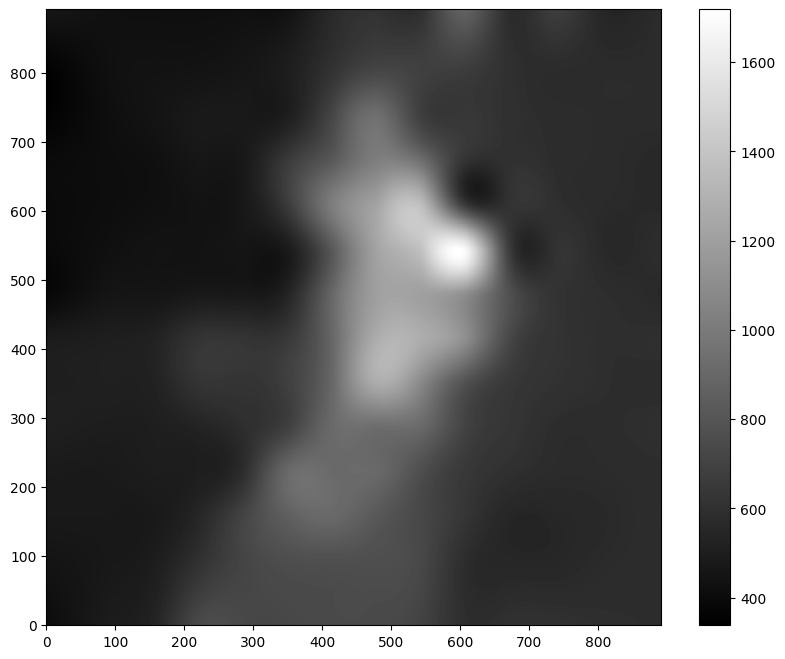

In [44]:
#show the background noise 
plt.imshow(bkg_rms, interpolation='nearest',cmap='gray',origin='lower')
plt.colorbar();

plt.savefig("background-noise.png",bbox_inches='tight',facecolor='white') 

In [25]:
data = np.ascontiguousarray(data, dtype=np.float64)
mask = ~np.isfinite(data)
if mask.any(): 
    median_val = np.nanmedian(data) 
    data[mask] = median_val 

In [45]:
data_sub = data - bkg

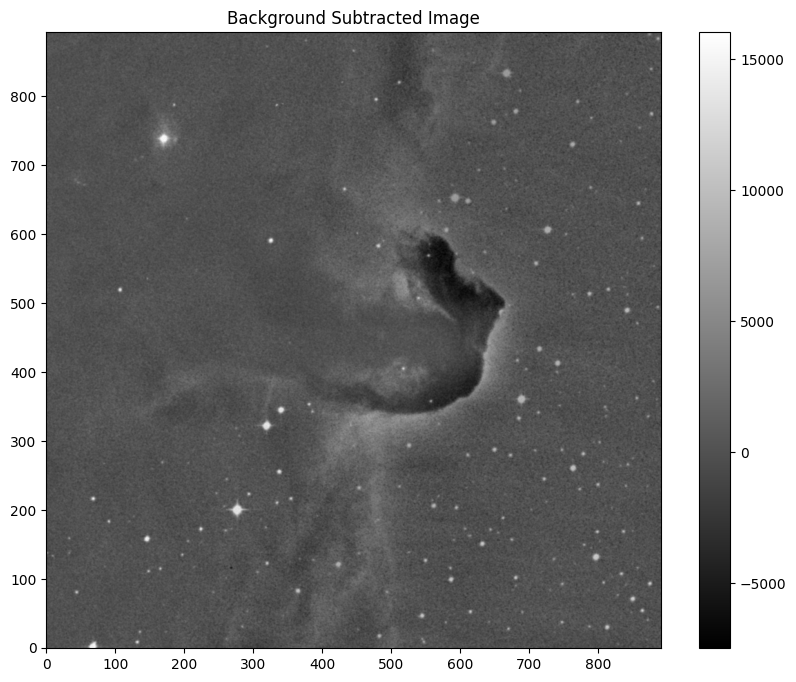

In [47]:
#plot the background-subtracted image
plt.imshow(data_sub, cmap='gray', origin='lower')
plt.title("Background Subtracted Image")
plt.colorbar()
plt.savefig("background-subtracted-image",bbox_inches='tight',facecolor='white') 

### Now we can extract the sources. 

In [21]:
data = np.ascontiguousarray(data, dtype=np.float64)
mask = ~np.isfinite(data)
if mask.any(): 
    median_val = np.nanmedian(data) 
    data[mask] = median_val 

In [28]:
objects = sep.extract(data_sub, thresh=1.5 * bkg.globalrms)
print(len(objects))

570


### Now we can plot detections. 

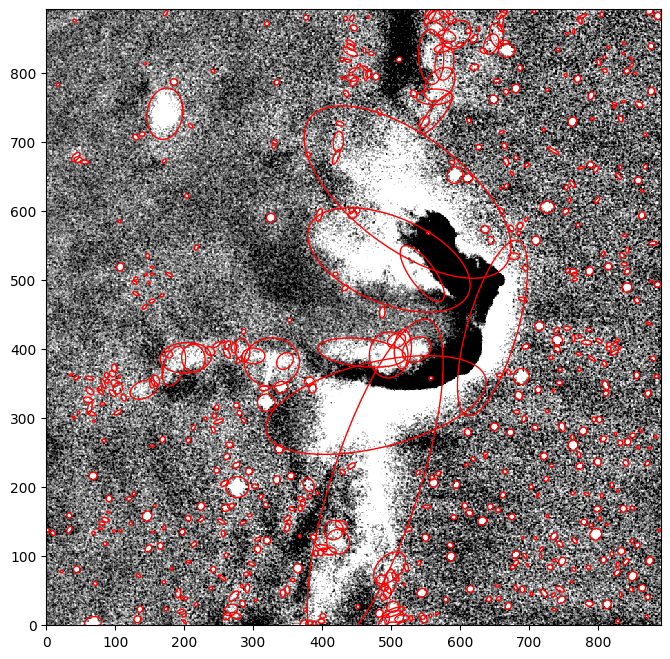

In [48]:
from matplotlib.patches import Ellipse 
fig, ax = plt.subplots()
m,s = np.mean(data_sub), np.std(data_sub) 
im = ax.imshow(data_sub, interpolation='nearest',cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower') 

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i], 
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none') 
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("source-detection.png",bbox_inches='tight',facecolor='white') 